# MMF1921 (Summer 2024) - Project 1
 
 The purpose of this program is to implement the following factor models
 
     a) Multi-factor OLS regression
     b) Fama-French 3-factor model
     c) LASSO
     d) Best Subset Selection
 
 and to use these factor models to estimate the asset expected returns and covariance matrix. 
 
These parameters will then be used to test the out-of-sample performance using MVO to construct optimal portfolios.
 
 Use can use this template to write your program.

     Student Name: Kaiwen Shen; 
     Student ID: 1009970239;

In [3]:
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from functions.BSS import *
from functions.FF import *
from functions.LASSO import *
from functions.MVO import *
from functions.OLS import *
import pandas as pd

adjClose = pd.read_csv("MMF1921_AssetPrices.csv", index_col=0)
factorRet = pd.read_csv("MMF1921_FactorReturns.csv", index_col=0)

In [5]:
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)

In [6]:
#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:, factorRet.columns != 'RF'];

In [7]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates = factorRet.index

In [8]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]

returns = returns - np.diag(riskFree.values) @ np.ones_like(returns.values)
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:, :]

In [9]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Define your initial parameters

In [10]:
#Initial budget to invest ($100,000)
initialVal = 100000

#Start of in-sample calibration period
calStart = pd.to_datetime('2008-01-01', format='%Y-%m-%d')
calEnd = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

#Start of out-of-sample test period
testStart = pd.to_datetime('2012-01-01', format='%Y-%m-%d')
testEnd = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)

#Number of investment periods (each investment period is 1 year long)
NoPeriods = 5

#Factor models
#Note: You must populate the functions OLS.py, FF.py, LASSO.py and BSS.py with your own code.
FMList = [OLS, FF, LASSO, BSS]
NoModels = len(FMList)

#Tags for the portfolios under the different factor models
tags = ['OLS portfolio', 'FF portfolio', 'LASSO portfolio', 'BSS portfolio']

# Collecting data for the input of factor combining model

In [11]:
train_period_ret = []
train_period_factor_ret = []
for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[(calStart <= returns.index) & (returns.index <= calEnd)]
    periodFactRet = factorRet[(calStart <= factorRet.index) & (factorRet.index <= calEnd)]

    # Update your calibration and out-of-sample test periods
    calStart = calStart + pd.offsets.DateOffset(years=1)
    calEnd = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)
    train_period_ret.append(periodReturns)
    train_period_factor_ret.append(periodFactRet)

In [25]:
mu,q,adj = OLS(train_period_ret[0], train_period_factor_ret[0], 0, 0)

In [26]:
np.mean(adj)

0.47045002683584547

In [27]:
mu,q,adj = FF(train_period_ret[0], train_period_factor_ret[0], 0, 0)

In [28]:
np.mean(adj)

0.42760676759512756

In [40]:
# for mvo, right now we are runnning the model targeting historical gmean return, and use mu and Q provided from the OLS model
position = MVO(mu, q, gmean(train_period_factor_ret[0]+ 1) - 1)

In [41]:
from matplotlib import pyplot as plt

<BarContainer object of 20 artists>

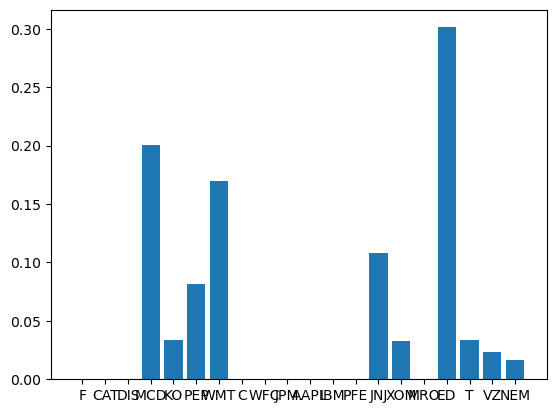

In [42]:
plt.bar(tickers, position)

In [43]:
train_period_ret[0].shape

(48, 20)

In [44]:
train_period_factor_ret[0].shape

(48, 8)

# 3. Construct and rebalance your portfolios

Here you will estimate your input parameters (exp. returns and cov. matrix etc) from the Fama-French factor models.
You will have to re-estimate your parameters at the start of each rebalance period, and then re-optimize and rebalance your portfolios accordingly.

Ensure you re-initialize the dates above if you run this cell repeatedly. 

In [ ]:
# Initiate counter for the number of observations per investment period
toDay = 0

# Preallocate the space for the per period value of the portfolios 
currentVal = {i: np.zeros(NoPeriods) for i in range(NoModels)}

# Number of assets
n = len(tickers)

# Preallocate space for the portfolio weights
x = {i: np.zeros([n, NoPeriods]) for i in range(NoModels)}

# Initialize dictionaries to hold Q, mu and the number of shares 
# for each model. These are overwritten at each rebalancing point
mu = {}
Q = {}
total_adj_r2 = []
NoShares = {}

# Empty lists to measure the value of the portfolio over the period
portfValue = {i: [] for i in range(NoModels)}

#--------------------------------------------------------------------------
# Set the value of lambda and K for the LASSO and BSS models, respectively
#--------------------------------------------------------------------------
lambda_ = 0.5
K = 4

for t in range(NoPeriods):
    adj_r2 = {}
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[(calStart <= returns.index) & (returns.index <= calEnd)]
    periodFactRet = factorRet[(calStart <= factorRet.index) & (factorRet.index <= calEnd)]

    current_price_idx = (calEnd - pd.offsets.DateOffset(days=7) <= adjClose.index) & (adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index) & (adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        for i in range(NoModels):
            currentVal[i][0] = initialVal  # all models start with the same amount of $
    else:
        for i in range(NoModels):
            currentVal[i][t] = (currentPrices @ NoShares[i].values.T).squeeze()

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay = toDay + len(periodPrices)

    # Calculate 'mu' and 'Q' using the 4 factor models.
    # Note: You need to write the code for the 4 factor model functions. 
    for i in range(NoModels):
        mu[i], Q[i], adj_r2[FMList[i].__name__] = FMList[i](periodReturns, periodFactRet, lambda_, K)

    # Optimize your portfolios to get the weights 'x'
    # Note: You need to write the code for MVO with no short sales
    for i in range(NoModels):
        # Define the target return as the geometric mean of the market 
        # factor for the current calibration period
        targetRet = gmean(periodFactRet.iloc[:, 0] + 1) - 1

        x[i][:, t] = MVO(mu[i], Q[i], targetRet)

        # Calculate the optimal number of shares of each stock you should hold
    for i in range(NoModels):
        # Number of shares your portfolio holds per stock
        NoShares[i] = x[i][:, t] * currentVal[i][t] / currentPrices

        # Weekly portfolio value during the out-of-sample window
        portfValue[i].append(periodPrices @ NoShares[i].values.T)

    # Update your calibration and out-of-sample test periods
    calStart = calStart + pd.offsets.DateOffset(years=1)
    calEnd = calStart + pd.offsets.DateOffset(years=4) - pd.offsets.DateOffset(days=1)

    testStart = testStart + pd.offsets.DateOffset(years=1)
    testEnd = testStart + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1)
    # append the adjusted r2
    total_adj_r2.append(adj_r2)
for i in range(NoModels):
    portfValue[i] = pd.concat(portfValue[i], axis=0)

# Overwrite into a dataframe
portfValue = pd.DataFrame([portfValue[i].values.squeeze() for i in range(NoModels)],
                          index=tags, columns=portfValue[0].index).T


# 4. Results

In [ ]:
#--------------------------------------------------------------------------
# 4.1 Evaluate any measures of fit of the regression models to assess their
# in-sample quality. You may want to modify Section 3 of this program to
# calculate the quality of fit each time the models are recalibrated.
#--------------------------------------------------------------------------

#--------------------------------------------------------------------------
# 4.2 Calculate the portfolio average return, variance (or standard 
# deviation), and any other performance and/or risk metric you wish to 
# include in your report.
#--------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------
# 4.3 Plot the portfolio wealth evolution 
# 
# Note: The code below plots all portfolios onto a single plot. However,
# you may want to split this into multiple plots for clarity, or to
# compare a subset of the portfolios. 
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title='Portfolio wealth evolution',
                ylabel='Total wealth',
                figsize=(6, 3),
                legend=True)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 4.4 Plot the portfolio weights period-over-period
#--------------------------------------------------------------------------
# OLS Portfolio weights

fig2 = plt.figure(2)
x[0][x[0] < 0] = 0
weights = pd.DataFrame(x[0][(x[0] > 0).any(axis=1)], index=tickers[(x[0] > 0).any(axis=1)])
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title='Portfolio weights',
                    ylabel='Weights', xlabel='Rebalance Period',
                    figsize=(6, 3),
                    legend=True, stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg")
#
# ###########################################################################
# # Program End